# 도구에 구성 전달하는 방법


<div class="admonition tip">
    <p class="admonition-title">전제 조건</p>
    <p>
        이 가이드는 다음에 익숙하다고 가정합니다:
        <ul>
            <li>
                <a href="https://python.langchain.com/docs/concepts/#runnable-interface">
                    실행 가능 인터페이스
                </a>
            </li>
            <li>
                <a href=" https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#tool-calling-agent">
                    도구 호출 에이전트
                </a>
            </li>      
            <li>
                <a href="https://python.langchain.com/docs/concepts/#tools">
                    도구
                </a>
            </li>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/concepts/streaming/">
                    스트리밍
                </a>
            </li>            
            <li>
                <a href="https://python.langchain.com/docs/concepts/#chat-models/">
                    챗 모델
                </a>
            </li>
        </ul>
    </p>
</div> 



실행 중에 도구에 사용자 ID와 같은 값을 전달해야 할 수도 있으며, 이는 보안상의 이유로 애플리케이션 로직에 의해 설정되어야 하고 LLM에 의해 제어되어서는 안 됩니다. LLM은 자신이 의도한 매개변수만 관리해야 합니다.

LangChain 도구는 `Runnable` 인터페이스를 사용하며, `invoke`와 같은 메서드는 `RunnableConfig` 유형 주석과 함께 config 인수를 통해 런타임 정보를 수락합니다.

다음 예제에서는 사용자의 좋아하는 애완동물을 관리하기 위한 도구를 설정하여, 항목을 추가하고 읽고 삭제하는 동시에 애플리케이션 로직을 통해 사용자 ID를 고정하고 챗 모델이 다른 매개변수를 제어하도록 합니다.


## 설정

먼저 필요한 패키지를 설치하고 API 키를 설정합시다.


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic


In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")


<div class="admonition tip">
    <p class="admonition-title">LangGraph 개발을 위한 <a href="https://smith.langchain.com">LangSmith</a> 설정하기</p>
    <p style="padding-top: 5px;">
        LangSmith에 가입하여 LangGraph 프로젝트의 문제를 신속하게 발견하고 성능을 향상시킬 수 있습니다. LangSmith를 사용하면 LangGraph로 구축한 LLM 앱의 trace 데이터를 사용하여 디버그, 테스트 및 모니터링할 수 있습니다. 시작하는 방법에 대한 자세한 내용은 <a href="https://docs.smith.langchain.com">여기</a>를 읽어보세요.
    </p>
</div>


## 도구와 모델 정의


!!! 경고 "설정 유형 주석"

각 도구 함수는 `config` 인수를 받을 수 있습니다. `config`가 함수에 올바르게 전달되도록 하려면 항상 `config` 인수에 대한 `RunnableConfig` 유형 주석을 추가해야 합니다. 예를 들어:

```python
def my_tool(tool_arg: str, config: RunnableConfig):
    ...
```


In [3]:
from typing import List

from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig

from langgraph.prebuilt import ToolNode

user_to_pets = {}


@tool(parse_docstring=True)
def update_favorite_pets(
    # NOTE: config arg does not need to be added to docstring, as we don't want it to be included in the function signature attached to the LLM
    pets: List[str],
    config: RunnableConfig,
) -> None:
    """Add the list of favorite pets.

    Args:
        pets: List of favorite pets to set.
    """
    user_id = config.get("configurable", {}).get("user_id")
    user_to_pets[user_id] = pets


@tool
def delete_favorite_pets(config: RunnableConfig) -> None:
    """Delete the list of favorite pets."""
    user_id = config.get("configurable", {}).get("user_id")
    if user_id in user_to_pets:
        del user_to_pets[user_id]


@tool
def list_favorite_pets(config: RunnableConfig) -> None:
    """List favorite pets if asked to."""
    user_id = config.get("configurable", {}).get("user_id")
    return ", ".join(user_to_pets.get(user_id, []))


tools = [update_favorite_pets, delete_favorite_pets, list_favorite_pets]


우리는 예제에서 Anthropic의 소규모 채팅 모델을 사용할 것입니다.


In [4]:
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


model = ChatAnthropic(model="claude-3-5-haiku-latest")


## ReAct 에이전트

그래프 구현을 설정해 봅시다 [ReAct 에이전트](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent). 이 에이전트는 쿼리를 입력받고, 쿼리를 해결하는 데 충분한 정보를 얻을 때까지 도구를 반복적으로 호출합니다. 우리는 미리 구축된 [`create_react_agent`][langgraph.prebuilt.chat_agent_executor.create_react_agent]와 방금 정의한 도구를 사용하여 Anthropic 모델을 사용할 것입니다. 참고: 도구는 `create_react_agent` 구현 내의 `model.bind_tools`를 통해 모델에 자동으로 추가됩니다.


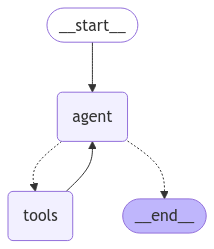

In [5]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

graph = create_react_agent(model, tools)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


## 사용해보세요!


In [6]:
from langchain_core.messages import HumanMessage

user_to_pets.clear()  # Clear the state

print(f"User information prior to run: {user_to_pets}")

inputs = {"messages": [HumanMessage(content="my favorite pets are cats and dogs")]}
for chunk in graph.stream(
    inputs, {"configurable": {"user_id": "123"}}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

print(f"User information after the run: {user_to_pets}")


User information prior to run: {}
================================ Human Message =================================

my favorite pets are cats and dogs
================================== Ai Message ==================================

[{'text': "I'll help you update your favorite pets using the `update_favorite_pets` function.", 'type': 'text'}, {'id': 'toolu_015jtecJ4jnosAfXEC3KADS2', 'input': {'pets': ['cats', 'dogs']}, 'name': 'update_favorite_pets', 'type': 'tool_use'}]
Tool Calls:
  update_favorite_pets (toolu_015jtecJ4jnosAfXEC3KADS2)
 Call ID: toolu_015jtecJ4jnosAfXEC3KADS2
  Args:
    pets: ['cats', 'dogs']
================================= Tool Message =================================
Name: update_favorite_pets

null
================================== Ai Message ==================================

Great! I've added cats and dogs to your list of favorite pets. Would you like to confirm the list or do anything else with it?
User information after the run: {'123': ['cats', 'dogs']

In [7]:
from langchain_core.messages import HumanMessage

print(f"User information prior to run: {user_to_pets}")

inputs = {"messages": [HumanMessage(content="what are my favorite pets")]}
for chunk in graph.stream(
    inputs, {"configurable": {"user_id": "123"}}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

print(f"User information prior to run: {user_to_pets}")


User information prior to run: {'123': ['cats', 'dogs']}
================================ Human Message =================================

what are my favorite pets
================================== Ai Message ==================================

[{'text': "I'll help you check your favorite pets by using the list_favorite_pets function.", 'type': 'text'}, {'id': 'toolu_01EMTtX5WtKJXMJ4WqXpxPUw', 'input': {}, 'name': 'list_favorite_pets', 'type': 'tool_use'}]
Tool Calls:
  list_favorite_pets (toolu_01EMTtX5WtKJXMJ4WqXpxPUw)
 Call ID: toolu_01EMTtX5WtKJXMJ4WqXpxPUw
  Args:
================================= Tool Message =================================
Name: list_favorite_pets

cats, dogs
================================== Ai Message ==================================

Based on the results, your favorite pets are cats and dogs.

Is there anything else you'd like to know about your favorite pets, or would you like to update the list?
User information prior to run: {'123': ['cats', 'dogs']

In [8]:
print(f"User information prior to run: {user_to_pets}")

inputs = {
    "messages": [
        HumanMessage(content="please forget what i told you about my favorite animals")
    ]
}
for chunk in graph.stream(
    inputs, {"configurable": {"user_id": "123"}}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

print(f"User information prior to run: {user_to_pets}")


User information prior to run: {'123': ['cats', 'dogs']}
================================ Human Message =================================

please forget what i told you about my favorite animals
================================== Ai Message ==================================

[{'text': "I'll help you delete the list of favorite pets. I'll use the delete_favorite_pets function to remove any previously saved list.", 'type': 'text'}, {'id': 'toolu_01JqpxgxdsDJFMzSLeogoRtG', 'input': {}, 'name': 'delete_favorite_pets', 'type': 'tool_use'}]
Tool Calls:
  delete_favorite_pets (toolu_01JqpxgxdsDJFMzSLeogoRtG)
 Call ID: toolu_01JqpxgxdsDJFMzSLeogoRtG
  Args:
================================= Tool Message =================================
Name: delete_favorite_pets

null
================================== Ai Message ==================================

The list of favorite pets has been deleted. If you'd like to create a new list of favorite pets in the future, just let me know.
User information